In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 



In [3]:
df = pd.read_csv(r"E:\gnn project\ForEx\JPYINR\JPY_INR_data.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,Date,Open_price,Day_high,Day_low,Closing_price,Currency Pair,Deseasonalized_Day_high,Deseasonalized_Day_low,...,EMA_100,EMA_200,EMA_50,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0,5230,2014-11-07,0.53595,0.53913,0.53381,0.53587,JPY/INR,0.539499,0.534094,...,0.535870,0.535870,0.535870,0.0,0.000000,0.000000e+00,0.000000,0.525811,0.537685,0.513938
1,1,5231,2014-11-10,0.53616,0.53963,0.53489,0.53593,JPY/INR,0.539796,0.535114,...,0.535871,0.535871,0.535872,0.0,0.000005,9.572650e-07,0.000004,0.525811,0.537685,0.513938
2,2,5232,2014-11-11,0.53137,0.53415,0.53018,0.53086,JPY/INR,0.534100,0.530327,...,0.535772,0.535821,0.535676,0.0,-0.000396,-7.842673e-05,-0.000318,0.525811,0.537685,0.513938
3,3,5233,2014-11-12,0.53080,0.53446,0.53045,0.53083,JPY/INR,0.534106,0.530339,...,0.535674,0.535771,0.535486,0.0,-0.000708,-2.043055e-04,-0.000504,0.525811,0.537685,0.513938
4,4,5234,2014-11-13,0.53094,0.53298,0.53065,0.53137,JPY/INR,0.532177,0.530143,...,0.535589,0.535727,0.535324,0.0,-0.000901,-3.436465e-04,-0.000557,0.525811,0.537685,0.513938


In [4]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'Open_price', 'Day_high',
       'Day_low', 'Closing_price', 'Currency Pair', 'Deseasonalized_Day_high',
       'Deseasonalized_Day_low', 'Deseasonalized_Open_price', 'EMA_100',
       'EMA_200', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
       'SMA', 'Upper Band', 'Lower Band'],
      dtype='object')

## Linear regression

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# === Load and prepare ===
# Assume df is already a pandas DataFrame with the columns you mentioned
df = df.copy()
df = df.dropna().reset_index(drop=True)

# --- Features and Target ---
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'   # or 'Deseasonalized_Day_high' etc.

X = df[features]
y = df[target]

# === Walk-forward validation ===
tscv = TimeSeriesSplit(n_splits=5)
lr = LinearRegression()

all_metrics = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    # --- Regression metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # --- Trading metrics ---
    pred_returns = pd.Series(y_pred, index=y_test.index).pct_change().fillna(0)
    actual_returns = df.loc[y_test.index, 'Closing_price'].pct_change().fillna(0)

    # Simple strategy: go long if predicted return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=y_test.index)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    # Directional Accuracy
    def directional_accuracy(actual, predicted):
        actual_diff = np.diff(actual)
        pred_diff = np.diff(predicted)
        return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

    da = directional_accuracy(y_test.values, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect Results ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)

y_pred_lr = y_pred
# === Average performance ===
print("\nAverage performance across folds:")
print(metrics_df.mean())


   Fold       MAE      RMSE        R2     ROI(%)    Sharpe  MaxDrawdown  \
0     1  0.005644  0.006419  0.950475  75.021947  0.434565    -0.010527   
1     2  0.001868  0.002406  0.981814  71.103101  0.414570    -0.008227   
2     3  0.001888  0.002677  0.984120  67.570441  0.376077    -0.012722   
3     4  0.002033  0.002612  0.995171  80.761170  0.393595    -0.011736   
4     5  0.001677  0.002265  0.990695  64.542307  0.365725    -0.008823   

   DirAcc(%)  
0  76.781609  
1  73.333333  
2  74.712644  
3  80.000000  
4  77.241379  

Average performance across folds:
Fold            3.000000
MAE             0.002622
RMSE            0.003276
R2              0.980455
ROI(%)         71.799793
Sharpe          0.396906
MaxDrawdown    -0.010407
DirAcc(%)      76.413793
dtype: float64


Rolling Walk-Forward MAE: 0.0018, RMSE: 0.0024, R2: 0.9976
Directional Accuracy: 78.51%


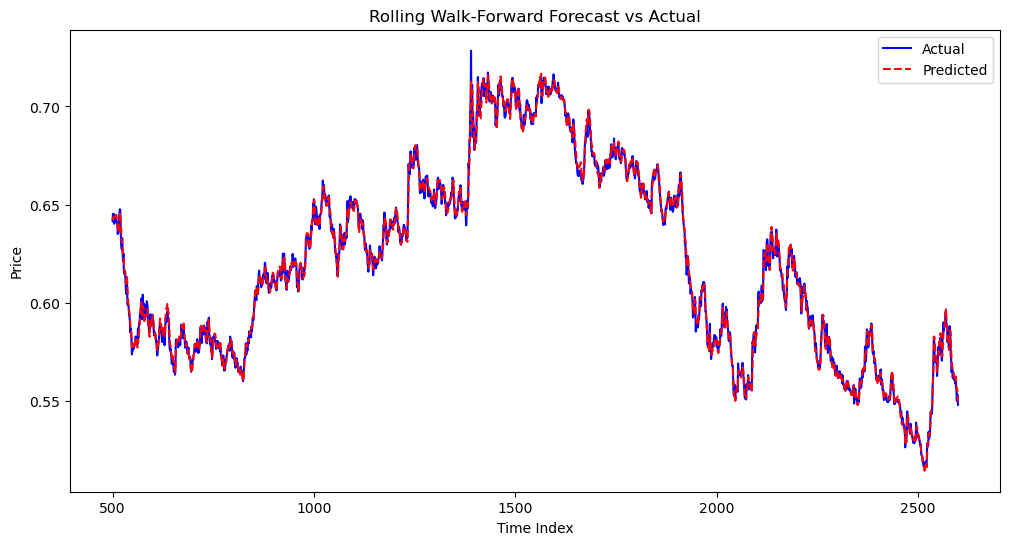

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'  # or try 'Deseasonalized_Day_high', etc.

X = df[features].values
y = df[target].values

# === Walk-forward params ===
train_window = 500   # how many samples in each rolling train set
test_window = 30     # how many samples to predict forward each step

lr = LinearRegression()

# Store results
all_preds, all_actuals, all_idx = [], [], []

for start in range(0, len(X) - train_window - test_window, test_window):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

# Convert to Series
y_actual_series = pd.Series(all_actuals, index=all_idx)
y_pred_series = pd.Series(all_preds, index=all_idx)

# === Metrics ===
mae = mean_absolute_error(y_actual_series, y_pred_series)
rmse = np.sqrt(mean_squared_error(y_actual_series, y_pred_series))
r2 = r2_score(y_actual_series, y_pred_series)

print(f"Rolling Walk-Forward MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Directional Accuracy
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

da = directional_accuracy(y_actual_series.values, y_pred_series.values)
print(f"Directional Accuracy: {da:.2f}%")



# Do same for each trained model

# === Plot results ===
plt.figure(figsize=(12,6))
plt.plot(y_actual_series.index, y_actual_series, label="Actual", color="blue")
plt.plot(y_pred_series.index, y_pred_series, label="Predicted", color="red", linestyle="dashed")
plt.title("Rolling Walk-Forward Forecast vs Actual")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.show()


In [7]:
import pickle

# Example for MLP
with open("lr_model.pkl", "wb") as f:
    pickle.dump(lr, f)

In [8]:
import numpy as np
np.bool = np.bool_


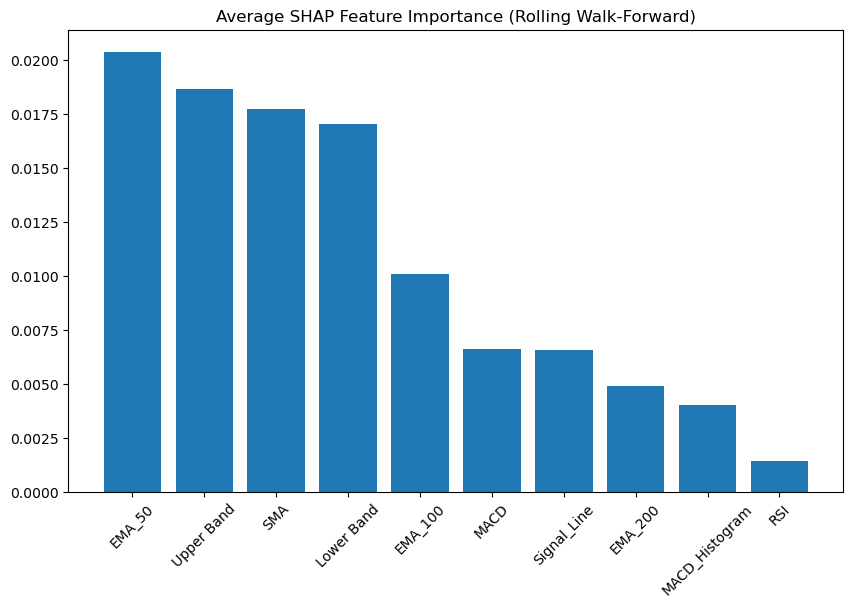

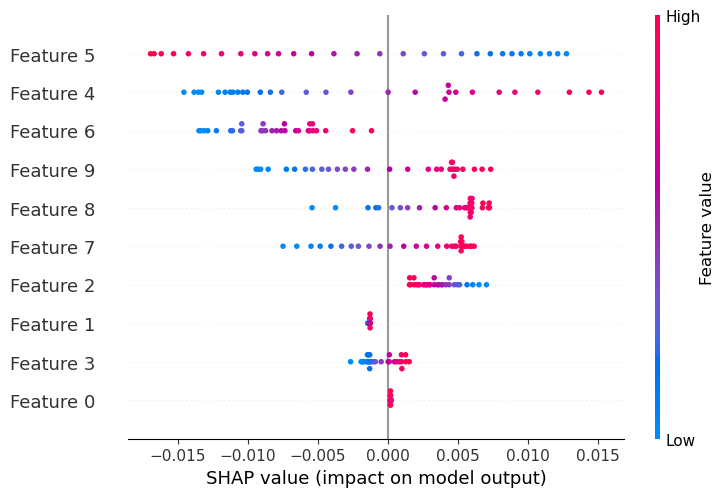

In [9]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === SHAP on Rolling Walk-Forward ===
train_window = 500
test_window = 30
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]

X = df[features].values
y = df['Closing_price'].values

lr = LinearRegression()

all_shap_values = []
all_feature_importance = []

for start in range(0, len(X) - train_window - test_window, test_window):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test = X[end:end+test_window]
    
    # Fit
    lr.fit(X_train, y_train)
    
    # SHAP Explainer
    explainer = shap.Explainer(lr, X_train)
    shap_values = explainer(X_test)
    
    # Aggregate mean absolute shap values (feature importance for this window)
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    all_feature_importance.append(mean_abs_shap)

# Convert to array
all_feature_importance = np.array(all_feature_importance)

# === Plot Average Feature Importance Across Walk-Forward ===
mean_importance = all_feature_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()

# === Optional: Waterfall/Beeswarm for last window ===
shap.plots.beeswarm(shap_values, show=True)


## KNN

In [10]:
np.int = int


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

    Fold       MAE      RMSE          R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.065350  0.073345  -67.146848 -2.259273 -0.168461    -0.026638   
1      2  0.065135  0.067262  -24.070259  0.409205  0.036754    -0.019823   
2      3  0.023182  0.028883  -18.746660  2.551920  0.170023    -0.010944   
3      4  0.021849  0.026960  -21.777331 -2.287690 -0.311115    -0.026760   
4      5  0.017777  0.021813   -7.319482  0.403293  0.040529    -0.015519   
..   ...       ...       ...         ...       ...       ...          ...   
65    66  0.027667  0.029070  -20.308734 -3.267408 -0.177434    -0.042652   
66    67  0.038475  0.040181 -110.424146  0.997823  0.099892    -0.009947   
67    68  0.044347  0.046324   -6.245279  1.762266  0.166303    -0.009574   
68    69  0.015427  0.018425   -3.682963 -1.060655 -0.060485    -0.027049   
69    70  0.010920  0.013731   -0.233768 -0.770900 -0.049667    -0.034325   

    DirAcc(%)  
0   41.379310  
1   41.379310  
2   58.620690  
3   34.4827

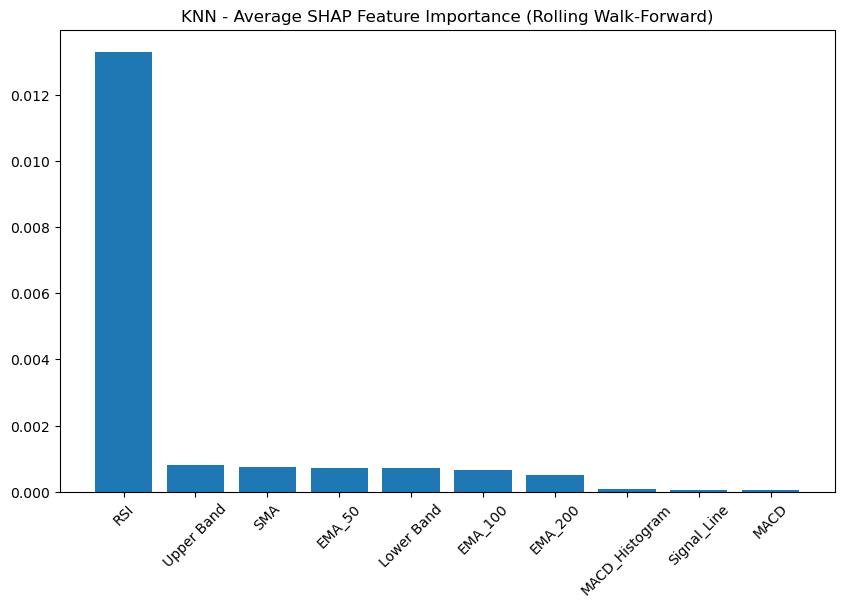

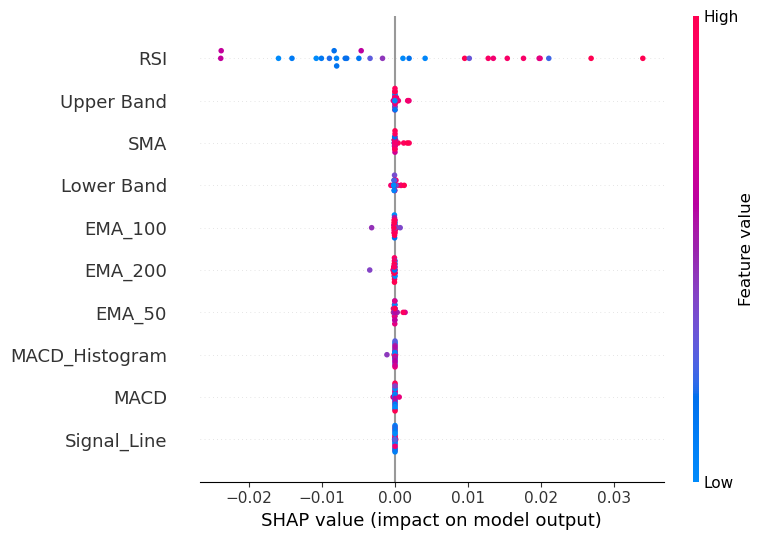

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

knn = KNeighborsRegressor(n_neighbors=5)

all_preds, all_actuals, all_idx = [], [], []
all_feature_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit model
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP (KernelExplainer) ---
    background = shap.sample(X_train, 100)  # subset for speed
    explainer = shap.KernelExplainer(knn.predict, background)
    shap_values = explainer.shap_values(X_test, nsamples=100)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    all_feature_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Predicted vs actual returns
    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    # Strategy: long if pred_return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics into DataFrame ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === Average SHAP importance ===
all_feature_importance = np.array(all_feature_importance)
mean_importance = all_feature_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("KNN - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()

# === SHAP Beeswarm for last window ===
shap.summary_plot(shap_values, X_test, feature_names=features)


## Catboost

    Fold       MAE      RMSE        R2     ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.004385  0.005790  0.575311   4.873725  0.533604    -0.003307   
1      2  0.015191  0.016314 -0.474873   2.693054  0.276459    -0.005983   
2      3  0.007883  0.009219 -1.011517   7.923107  0.493667    -0.010944   
3      4  0.002393  0.003102  0.698416   2.932658  0.310328    -0.011529   
4      5  0.003839  0.004670  0.618632   4.934435  0.535540    -0.003458   
..   ...       ...       ...       ...        ...       ...          ...   
65    66  0.012425  0.014220 -4.098378  -4.411738 -0.396409    -0.044042   
66    67  0.007788  0.008707 -4.232625   2.705576  0.277877    -0.005372   
67    68  0.010177  0.010833  0.603737  11.656444  0.519357    -0.011394   
68    69  0.007366  0.008499  0.003644   7.382576  0.568654    -0.006678   
69    70  0.002614  0.003257  0.930565   2.499396  0.232729     0.000000   

    DirAcc(%)  
0   82.758621  
1   72.413793  
2   86.206897  
3   68.965517  
4   89.

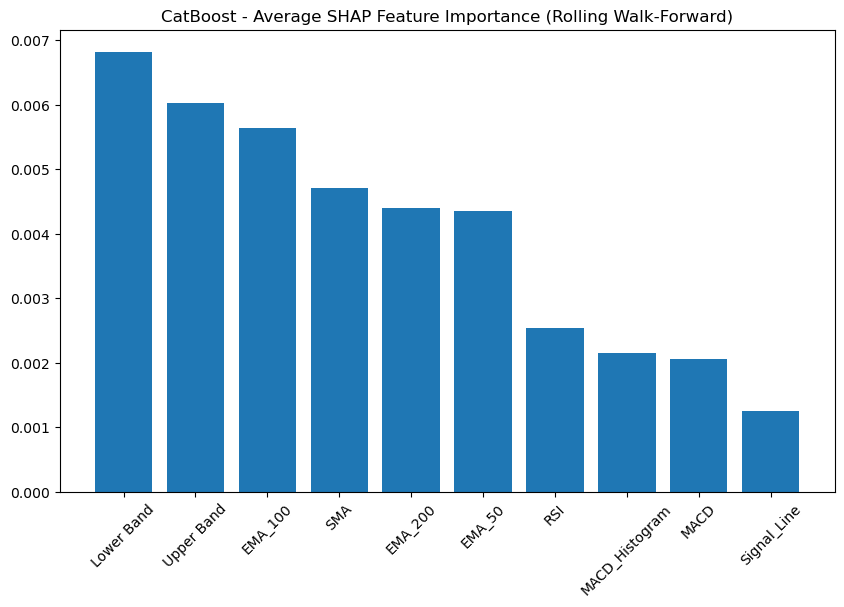

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

cat = CatBoostRegressor(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=0,
    random_seed=42
)

all_preds, all_actuals, all_idx = [], [], []
all_shap_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Wrap into CatBoost Pool
    train_pool = Pool(X_train, y_train, feature_names=features)
    test_pool = Pool(X_test, y_test, feature_names=features)

    # Fit model
    cat.fit(train_pool)
    y_pred = cat.predict(test_pool)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP values from CatBoost ---
    shap_values = cat.get_feature_importance(type="ShapValues", data=test_pool)
    # Last column of shap_values is expected_value, drop it
    shap_contribs = shap_values[:, :-1]
    mean_abs_shap = np.abs(shap_contribs).mean(axis=0)
    all_shap_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

y_pred_cat = y_pred

# === SHAP importance (average) ===
all_shap_importance = np.array(all_shap_importance)
mean_importance = all_shap_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("CatBoost - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()


In [13]:
import pickle

# Example for MLP
with open("cat_model.pkl", "wb") as f:
    pickle.dump(cat, f)

## Gradient Boosting

    Fold       MAE      RMSE        R2     ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.011374  0.013211 -1.210883   1.321849  0.169204    -0.005901   
1      2  0.027751  0.030327 -4.096564   0.813378  0.067954    -0.011651   
2      3  0.008432  0.010301 -1.511685   8.747129  0.611542    -0.002336   
3      4  0.002669  0.003431  0.631183   2.474650  0.242824    -0.012470   
4      5  0.004215  0.005069  0.550687   3.768780  0.346939    -0.008376   
..   ...       ...       ...       ...        ...       ...          ...   
65    66  0.010783  0.012647 -3.033354   2.104308  0.117200    -0.009841   
66    67  0.007050  0.007858 -3.261826   1.515415  0.143707    -0.010583   
67    68  0.008608  0.012042  0.510381  11.597579  0.524470    -0.006418   
68    69  0.007041  0.008233  0.065064   3.856933  0.248005    -0.017155   
69    70  0.004401  0.005380  0.810591   0.100945  0.008071    -0.020844   

    DirAcc(%)  
0   55.172414  
1   58.620690  
2   86.206897  
3   68.965517  
4   82.

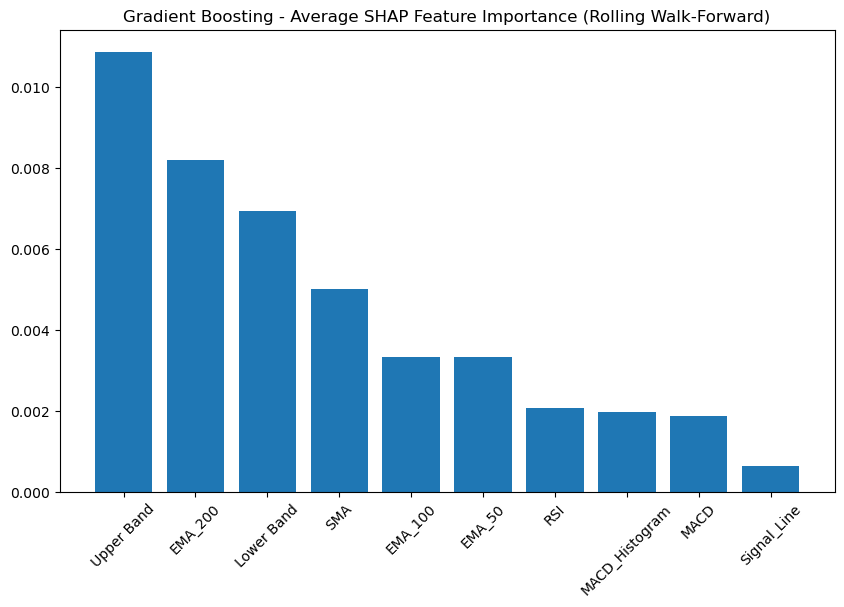

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

# === Prepare Data ===
df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

all_preds, all_actuals, all_idx = [], [], []
all_shap_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit model
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP values ---
    explainer = shap.TreeExplainer(gbr)
    shap_values = explainer.shap_values(X_test)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    all_shap_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === SHAP importance (average) ===
all_shap_importance = np.array(all_shap_importance)
mean_importance = all_shap_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("Gradient Boosting - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()


## Light GBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1662
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 10
[LightGBM] [Info] Start training from score 0.566037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

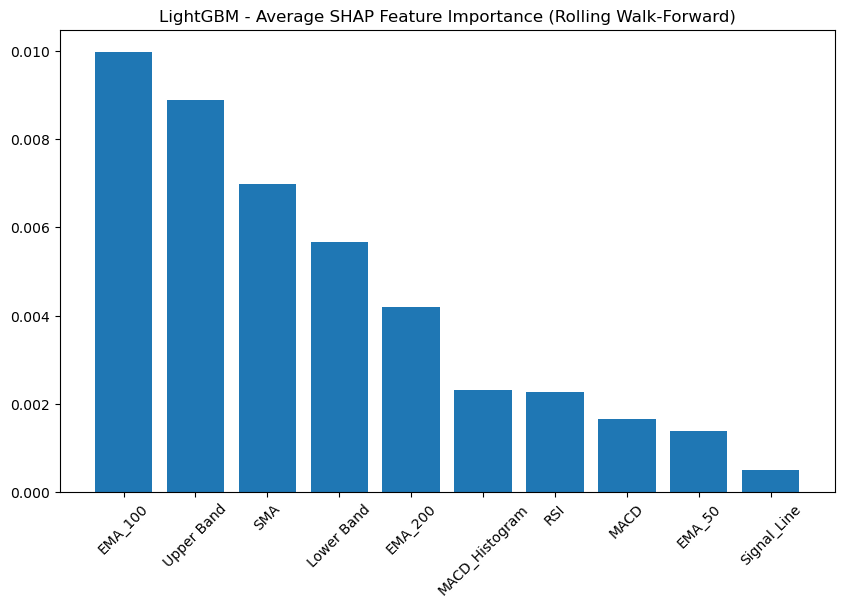

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
#df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

all_preds, all_actuals, all_idx = [], [], []
all_shap_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Rolling walk-forward loop ===
for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit model
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP values ---
    explainer = shap.TreeExplainer(lgbm)
    shap_values = explainer.shap_values(X_test)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    all_shap_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    # Simple trading strategy: long if predicted return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === SHAP importance (average) ===
all_shap_importance = np.array(all_shap_importance)
mean_importance = all_shap_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

y_pred_lgb = y_pred

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("LightGBM - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()


In [16]:
import pickle

# Example for MLP
with open("lgbm_model.pkl", "wb") as f:
    pickle.dump(lgbm, f)

# MLP 


==== MLPRegressor ====
    Fold       MAE      RMSE          R2     ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.092648  0.094175 -111.350022   5.109077  0.545613    -0.002988   
1      2  0.168679  0.170207 -159.539128   1.359939  0.119321    -0.017188   
2      3  0.005953  0.006988   -0.155838   6.290946  0.406803    -0.006598   
3      4  0.004665  0.005957   -0.111840   3.496975  0.386045    -0.004416   
4      5  0.006451  0.007960   -0.107810   4.344930  0.431610    -0.009333   
..   ...       ...       ...         ...        ...       ...          ...   
65    66  0.079586  0.098386 -243.078732   4.715947  0.297486    -0.000929   
66    67  0.020203  0.027484  -51.132327   2.344150  0.245565    -0.007653   
67    68  0.024438  0.024972   -1.105421  13.485545  0.643913    -0.001836   
68    69  0.006011  0.007280    0.268960   8.056392  0.652068    -0.002345   
69    70  0.060690  0.071554  -32.504337   3.174911  0.244371    -0.008790   

    DirAcc(%)  
0   86.206897  
1   62.

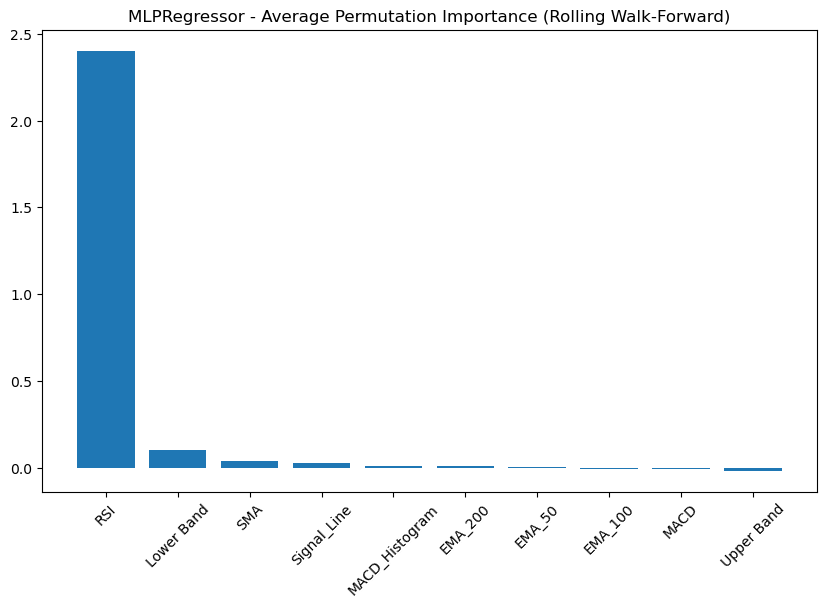


==== SVR ====
    Fold       MAE      RMSE         R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.007081  0.008669   0.047926 -0.967378 -0.074837    -0.029978   
1      2  0.047131  0.054934 -15.722927 -2.423323 -0.181798    -0.036361   
2      3  0.013298  0.014281  -3.827661  8.041099  0.576573    -0.002756   
3      4  0.006123  0.006627  -0.376300  3.183224  0.317441    -0.011196   
4      5  0.007127  0.008790  -0.350969  0.132405  0.011244    -0.018143   
..   ...       ...       ...        ...       ...       ...          ...   
65    66  0.010075  0.013421  -3.541756 -2.727065 -0.148724    -0.039440   
66    67  0.005028  0.006396  -1.823031 -2.235581 -0.325378    -0.022191   
67    68  0.017909  0.021702  -0.590256  2.566984  0.193355    -0.010502   
68    69  0.006701  0.007672   0.188036  3.781208  0.237499    -0.019029   
69    70  0.003832  0.004927   0.841154 -0.386162 -0.032994    -0.014718   

    DirAcc(%)  
0   55.172414  
1   55.172414  
2   82.758621  
3   82.7

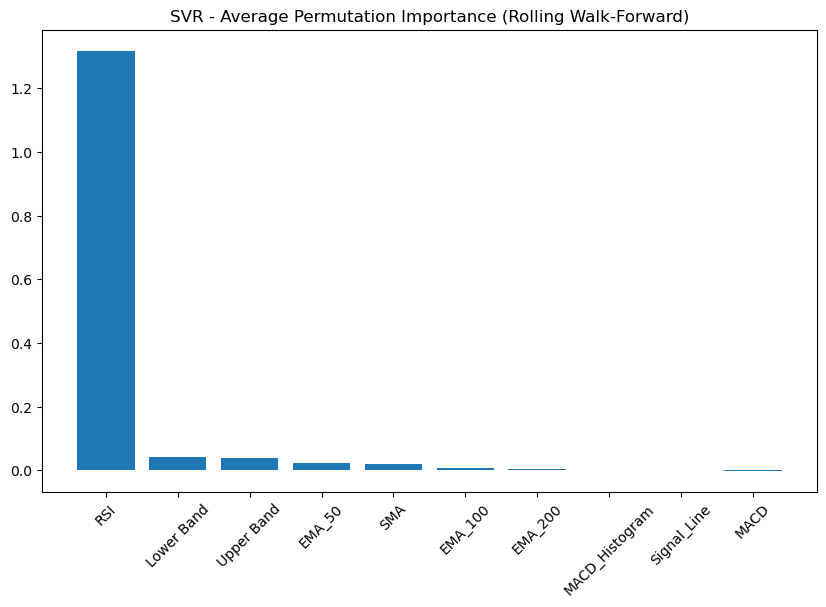

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

# Models
mlp = MLPRegressor(hidden_layer_sizes=(64,32),
                   activation='relu',
                   solver='adam',
                   max_iter=500,
                   random_state=42)

svm = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)

models = {
    "MLPRegressor": mlp,
    "SVR": svm
}

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

results = {}
all_model_preds = {}  # store final predictions for each model

# === Loop for each model ===
for model_name, model in models.items():
    all_preds, all_actuals, all_idx = [], [], []
    all_importance, all_metrics = [], []

    for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
        end = start + train_window
        X_train, y_train = X[start:end], y[start:end]
        X_test, y_test = X[end:end+test_window], y[end:end+test_window]

        # Fit model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_preds.extend(y_pred)
        all_actuals.extend(y_test)
        all_idx.extend(range(end, end+test_window))

        # --- Feature Importance via Permutation (only works for some models)
        try:
            perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
            mean_importance = perm.importances_mean
            all_importance.append(mean_importance)
        except Exception:
            pass

        # --- Metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
        actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

        strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
        strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

        roi = strategy_returns.sum() * 100
        sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
        cumulative = (1 + strategy_returns).cumprod()
        drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
        max_dd = drawdown.min()

        da = directional_accuracy(y_test, y_pred)

        all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

    # Save results
    metrics_df = pd.DataFrame(all_metrics, columns=[
        'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
    ])
    results[model_name] = {
        "metrics": metrics_df,
        "avg_metrics": metrics_df.mean(),
        "importance": np.array(all_importance).mean(axis=0) if all_importance else None,
        "preds": np.array(all_preds),       # save predictions
        "actuals": np.array(all_actuals),   # save actuals
        "index": np.array(all_idx)
    }
    all_model_preds[model_name] = np.array(all_preds)

    # === Print metrics ===
    print(f"\n==== {model_name} ====")
    print(metrics_df)
    print("\nAverage performance across folds:")
    print(metrics_df.mean())

    # === Plot feature importance (if available) ===
    if results[model_name]["importance"] is not None:
        sorted_idx = np.argsort(results[model_name]["importance"])[::-1]
        plt.figure(figsize=(10,6))
        plt.bar(range(len(features)), results[model_name]["importance"][sorted_idx])
        plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
        plt.title(f"{model_name} - Average Permutation Importance (Rolling Walk-Forward)")
        plt.show()

# === Expose separate predictions for later usage (e.g. DM test) ===
y_pred_mlp = results["MLPRegressor"]["preds"]
y_pred_svr = results["SVR"]["preds"]
y_actual_series = results["MLPRegressor"]["actuals"]  # same across models


In [18]:
import pickle

# Example for MLP
with open("mlp_model.pkl", "wb") as f:
    pickle.dump(mlp, f)

In [19]:
import pickle

# Example for MLP
with open("svr_model.pkl", "wb") as f:
    pickle.dump(svm, f)

## Bilstm

In [20]:
pip install --upgrade typing_extensions


Note: you may need to restart the kernel to use updated packages.


    Fold       MAE      RMSE          R2     ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.079929  0.080730  -72.918381  -0.914414 -0.091308    -0.027038   
1      2  0.066789  0.067216 -104.786924  -0.429631 -0.089251    -0.006824   
2      3  0.020664  0.021040  -28.174577  -1.184393 -0.150602    -0.020899   
3      4  0.008927  0.009979   -2.710949   0.983328  0.181598    -0.007151   
4      5  0.009713  0.011352   -0.584399   0.109556  0.017120    -0.015164   
..   ...       ...       ...         ...        ...       ...          ...   
65    66  0.045669  0.046184 -100.252257  -0.879339 -0.082984    -0.023920   
66    67  0.045521  0.045858 -137.198950  -1.568922 -0.291852    -0.019591   
67    68  0.045471  0.046280   -6.612926  10.369086  0.644799    -0.006418   
68    69  0.008344  0.008860   -0.549148   1.238976  0.194863    -0.006678   
69    70  0.006120  0.007262    0.214752  -4.034113 -0.417589    -0.039793   

    DirAcc(%)  
0   63.157895  
1   57.894737  
2   42.105263  

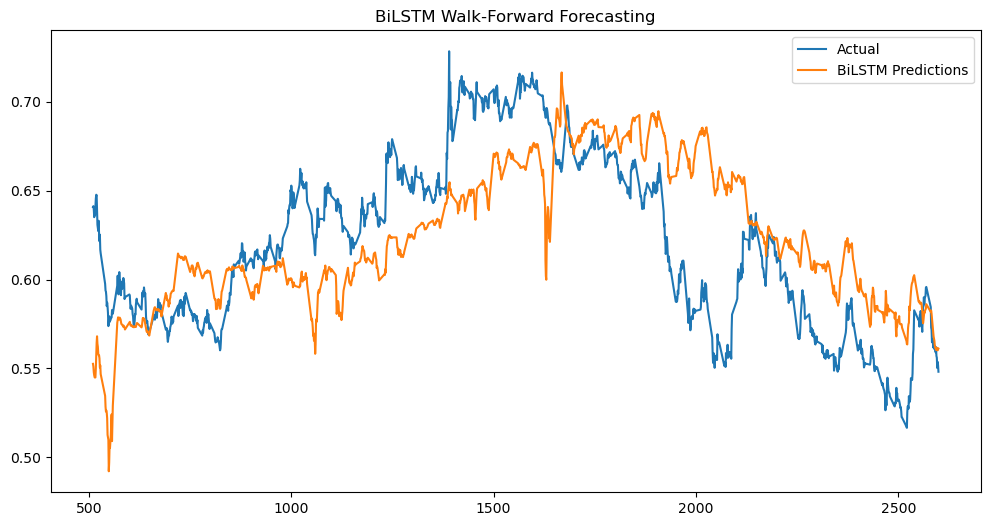

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

# ====================
# Prepare Data
# ====================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32)

# scale optional: you can normalize if needed
# ====================
# BiLSTM Model
# ====================
class BiLSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(BiLSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, 1)  # *2 for bidirectional

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        return self.fc(out)

# ====================
# Helper Functions
# ====================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

def create_sequences(X, y, seq_len=10):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:(i+seq_len)])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

# ====================
# Walk-Forward Params
# ====================
train_window = 500
test_window = 30
seq_len = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds, all_actuals, all_idx, all_metrics = [], [], [], []

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train_raw, y_train_raw = X[start:end], y[start:end]
    X_test_raw, y_test_raw = X[end:end+test_window], y[end:end+test_window]

    # Create sequences
    X_train, y_train = create_sequences(X_train_raw, y_train_raw, seq_len)
    X_test, y_test = create_sequences(X_test_raw, y_test_raw, seq_len)

    train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train).unsqueeze(-1))
    test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test).unsqueeze(-1))

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

    # Init model
    model = BiLSTMRegressor(input_dim=X.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    model.train()
    for epoch in range(20):  # keep small for walk-forward
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Predict
    # Predict
    # Predict
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().squeeze().tolist()   # stay as Python list
            preds_list.extend(preds)
            actual_list.extend(yb.squeeze().tolist())



    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end+seq_len, end+seq_len+len(preds_list)))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)
    da = directional_accuracy(actual_list, preds_list)

    # Trading metrics
    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ====================
# Collect Results
# ====================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_bilstm = preds_list
# ====================
# Plot Predictions
# ====================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="BiLSTM Predictions")
plt.legend()
plt.title("BiLSTM Walk-Forward Forecasting")
plt.show()


## CNN

Shape: (2591, 30, 10) (2591,)
    Fold       MAE      RMSE           R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.085675  0.096362   -50.456315 -5.287606 -0.316877    -0.057266   
1      2  0.019423  0.022297   -10.767473 -1.166722 -0.083928    -0.022579   
2      3  0.301222  0.323577 -3279.990414  0.040361  0.004803    -0.017462   
3      4  0.039929  0.043656   -32.323721 -0.737038 -0.076917    -0.015034   
4      5  0.045676  0.051427   -49.571084  0.816254  0.072965    -0.011749   
..   ...       ...       ...          ...       ...       ...          ...   
64    65  0.114899  0.124864  -392.131492 -0.624580 -0.030827    -0.036382   
65    66  0.057355  0.059918  -246.778937  0.155402  0.016805    -0.008254   
66    67  0.039123  0.042227    -5.020482  8.224249  0.399548    -0.006418   
67    68  0.220497  0.223016  -685.064551 -0.206717 -0.014839    -0.029586   
68    69  0.014051  0.015357    -0.543326 -4.427141 -0.300626    -0.046637   

    DirAcc(%)  
0   37.931034  
1

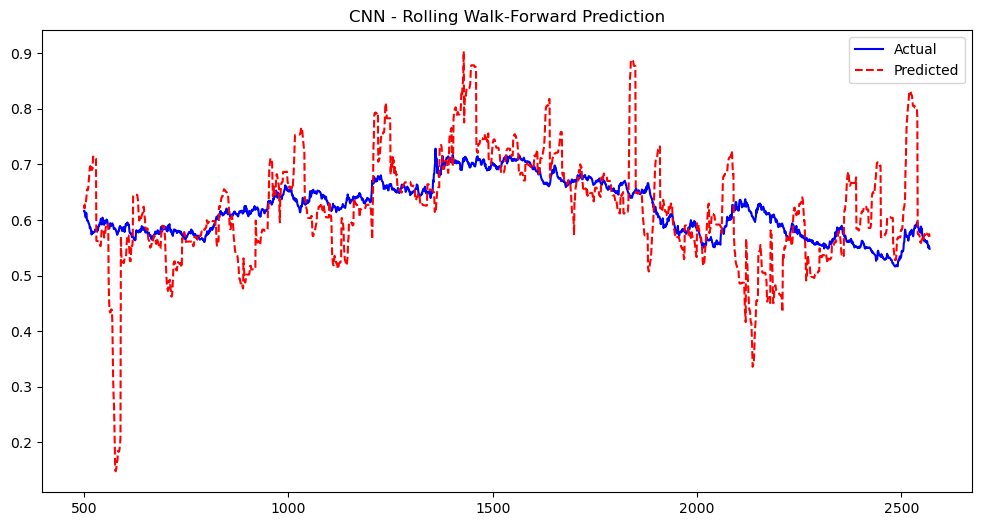

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # how many past days to use
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

# Function to build sequences
def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# CNN Model
# ===================
class CNN1D(nn.Module):
    def __init__(self, input_dim, lookback):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # input: (batch, lookback, features)
        x = x.permute(0, 2, 1)   # -> (batch, features, lookback)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = CNN1D(input_dim=X_train.shape[2], lookback=lookback).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):  # epochs per fold
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())


    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

y_pred_cnn = preds_list
# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("CNN - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## CNN- LSTM


Shape: (2591, 30, 10) (2591,)
    Fold       MAE      RMSE         R2     ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.022133  0.023603  -2.087154  -3.494907 -0.322193    -0.034550   
1      2  0.015202  0.016063  -5.107091   0.821010  0.052013    -0.019700   
2      3  0.010738  0.011732  -3.313360   0.808810  0.100966    -0.009991   
3      4  0.007946  0.010090  -0.780068  -1.293288 -0.129996    -0.019720   
4      5  0.007320  0.008435  -0.360476  -0.986813 -0.097568    -0.012865   
..   ...       ...       ...        ...        ...       ...          ...   
64    65  0.005500  0.006798  -0.165123   1.344802  0.091059    -0.009673   
65    66  0.011975  0.012638 -10.022390  -2.369400 -0.363854    -0.023565   
66    67  0.006386  0.007770   0.796174  10.337976  0.492053    -0.006418   
67    68  0.008095  0.010231  -0.443844   1.345857  0.075567    -0.031217   
68    69  0.007370  0.008460   0.531625  -4.410898 -0.425784    -0.048126   

    DirAcc(%)  
0   44.827586  
1   51.724138

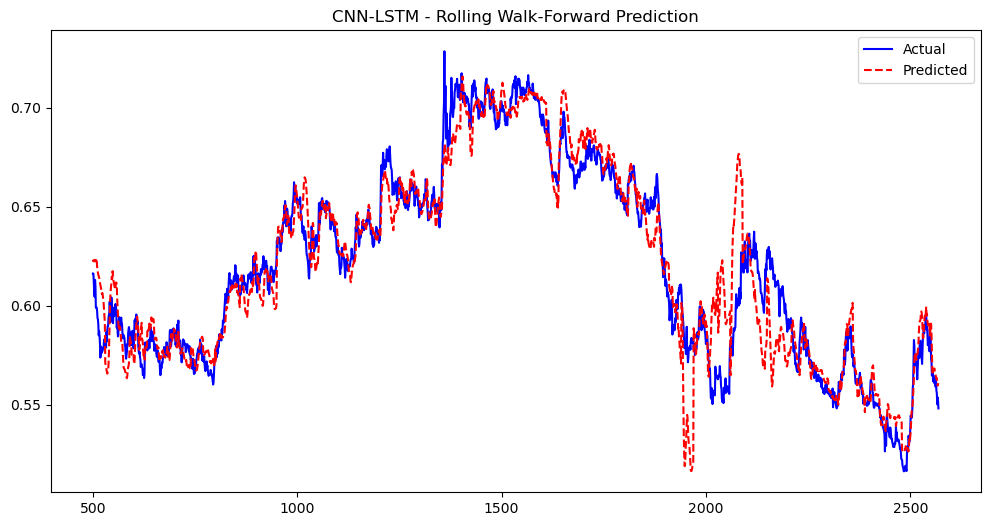

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # days of history per sample
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# CNN-LSTM Model
# ===================
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Input shape: (batch, lookback, features)
        x = x.permute(0, 2, 1)         # -> (batch, features, lookback)
        x = self.conv1(x)              # -> (batch, 32, lookback-2)
        x = self.relu(x)
        x = x.permute(0, 2, 1)         # -> (batch, seq_len, 32)
        out, _ = self.lstm(x)          # -> (batch, seq_len, hidden_dim)
        out = out[:, -1, :]            # take last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = CNN_LSTM(input_dim=X_train.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())

    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("CNN-LSTM - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## GRU

Shape: (2591, 30, 10) (2591,)
    Fold       MAE      RMSE          R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.021596  0.024991   -2.461032 -0.470764 -0.046632    -0.011787   
1      2  0.071130  0.072778 -124.371010 -0.463139 -0.024513    -0.025074   
2      3  0.054158  0.056166  -97.852796  0.025259  0.004654    -0.005687   
3      4  0.007465  0.009089   -0.444412 -1.681872 -0.146541    -0.029409   
4      5  0.005787  0.007601   -0.104603 -0.191991 -0.011636    -0.023796   
..   ...       ...       ...         ...       ...       ...          ...   
64    65  0.007737  0.008870   -0.983840 -3.167427 -0.305640    -0.032876   
65    66  0.002063  0.002454    0.584349  0.554700  0.062306    -0.009465   
66    67  0.010457  0.012612    0.462935  7.775763  0.414398    -0.006418   
67    68  0.010605  0.014290   -1.816891  0.022775  0.001809    -0.019496   
68    69  0.006917  0.008446    0.533184 -3.009905 -0.231353    -0.032451   

    DirAcc(%)  
0   55.172414  
1   48.275862

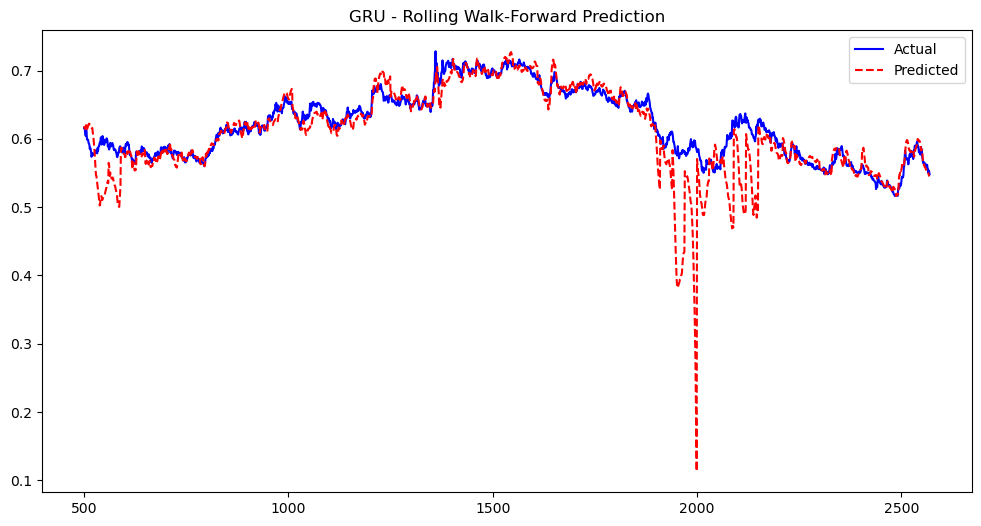

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # how many past days per sequence
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# GRU Model
# ===================
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim,
                          num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Input shape: (batch, lookback, features)
        out, _ = self.gru(x)           # (batch, seq_len, hidden_dim)
        out = out[:, -1, :]            # take last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = GRUModel(input_dim=X_train.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):  # epochs per fold
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())

    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_gru = preds_list
# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("GRU - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## LSTM


Shape: (2591, 30, 10) (2591,)
    Fold       MAE      RMSE          R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.084971  0.117897  -76.024287 -0.008115 -0.182574    -0.000081   
1      2  0.064272  0.066015 -102.153826  0.341220  0.020839    -0.020902   
2      3  0.026894  0.027155  -22.107065  0.361150  0.036992    -0.018094   
3      4  0.005934  0.006960    0.153111 -0.902164 -0.115794    -0.011782   
4      5  0.007694  0.008869   -0.504168 -1.122062 -0.105673    -0.011749   
..   ...       ...       ...         ...       ...       ...          ...   
64    65  0.004372  0.005697    0.181648 -0.757675 -0.045971    -0.021432   
65    66  0.013007  0.013245  -11.106851  0.565149  0.061241    -0.008254   
66    67  0.009885  0.011398    0.561331  8.695247  0.431776    -0.006418   
67    68  0.010547  0.012803   -1.261188 -0.711062 -0.053803    -0.026691   
68    69  0.003571  0.004410    0.872735 -4.408640 -0.350157    -0.045485   

    DirAcc(%)  
0   55.172414  
1   48.275862

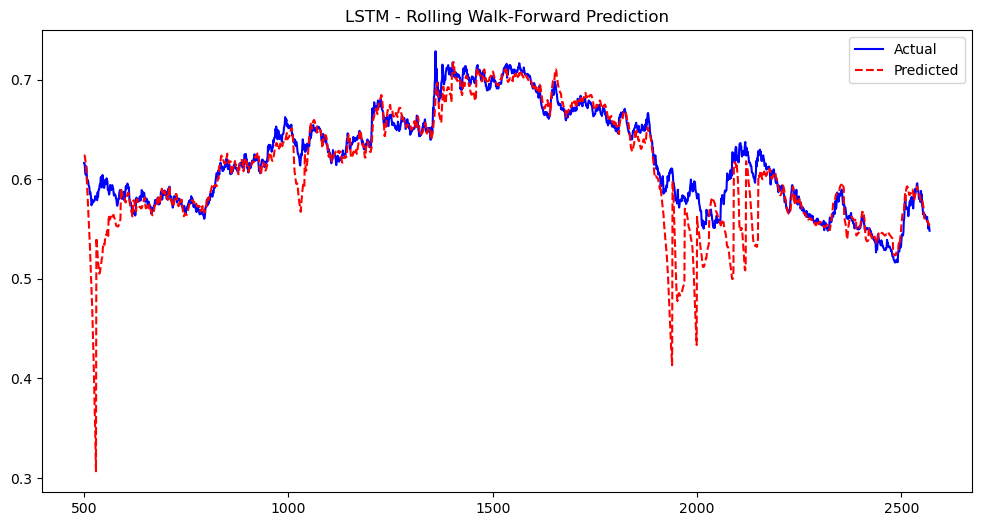

In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===================
# Parameters
# ===================
lookback = 30   # how many past days per sequence
train_window = 500
test_window = 30
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===================
# Prepare Data
# ===================
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df[target].values

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, lookback)
print("Shape:", X_seq.shape, y_seq.shape)  # (samples, lookback, features)

# ===================
# LSTM Model
# ===================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Input shape: (batch, lookback, features)
        out, _ = self.lstm(x)          # (batch, seq_len, hidden_dim)
        out = out[:, -1, :]            # take last timestep
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ===================
# Walk-forward validation
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

all_metrics = []
all_preds, all_actuals, all_idx = [], [], []

for fold, start in enumerate(range(0, len(X_seq) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X_seq[start:end], y_seq[start:end]
    X_test, y_test = X_seq[end:end+test_window], y_seq[end:end+test_window]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = LSTMModel(input_dim=X_train.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # --- Train ---
    model.train()
    for epoch in range(20):  # epochs per fold
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- Predict ---
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().detach().flatten().tolist()
            preds_list.extend(preds)
            actual_list.extend(yb.flatten().tolist())

    all_preds.extend(preds_list)
    all_actuals.extend(actual_list)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(actual_list, preds_list)
    rmse = np.sqrt(mean_squared_error(actual_list, preds_list))
    r2 = r2_score(actual_list, preds_list)

    pred_returns = pd.Series(preds_list).pct_change().fillna(0)
    actual_returns = pd.Series(actual_list).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(actual_list, preds_list)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# ===================
# Collect metrics
# ===================
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

y_pred_lstm = preds_list

# ===================
# Plot actual vs predicted
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds, label="Predicted", color="red", linestyle="dashed")
plt.title("LSTM - Rolling Walk-Forward Prediction")
plt.legend()
plt.show()


## PROPHET

14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing
14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:21 - cmdstanpy - INFO - Chain [1] start processing
14:53:21 - cmdstanpy - INFO - Chain [1] done processing
14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing
14:53:24 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1]


=== Prophet WITH Regressors ===
    Fold       MAE      RMSE        R2     ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.003193  0.004502  0.743231   5.723243  0.643638    -0.000371   
1      2  0.008089  0.008636  0.586667   2.748821  0.283075    -0.004894   
2      3  0.001818  0.002308  0.873967   9.031369  0.644158     0.000000   
3      4  0.001525  0.001753  0.903717   4.848607  0.541720    -0.002136   
4      5  0.002425  0.002775  0.865367   4.867980  0.522422    -0.004049   
..   ...       ...       ...       ...        ...       ...          ...   
65    66  0.002097  0.002507  0.841468   4.705549  0.294846    -0.003249   
66    67  0.007828  0.008795 -4.338600   3.019418  0.338335    -0.000586   
67    68  0.003133  0.004716  0.924894  13.339942  0.632736    -0.002761   
68    69  0.005234  0.006035  0.497521   8.856580  0.669760    -0.003160   
69    70  0.005943  0.006380  0.733608   3.338939  0.258057    -0.008823   

    DirAcc(%)  
0   89.655172  
1   72.413793  
2   93

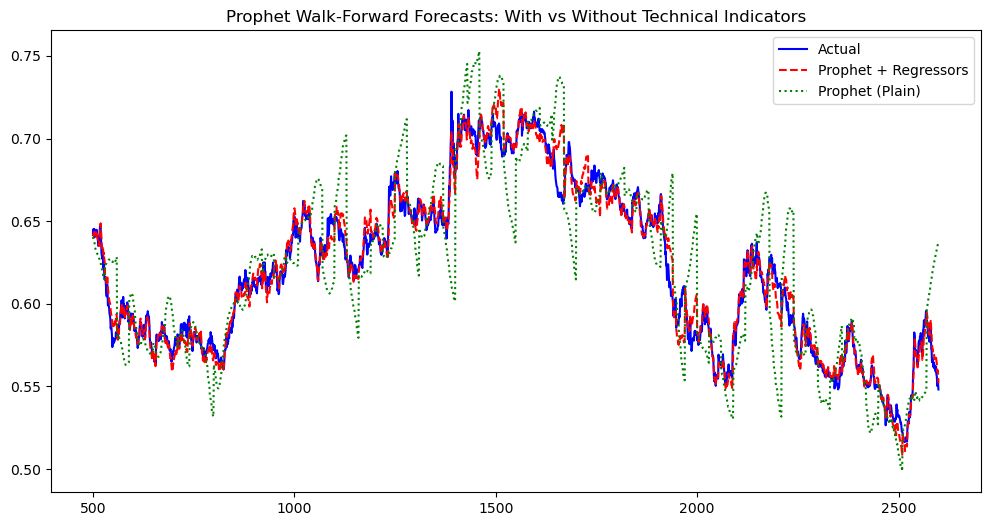

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ===================
# Parameters
# ===================
train_window = 500
test_window = 30

# Prophet requires 'ds' and 'y'
df_prophet = df[['Date', 'Closing_price',
                 'EMA_100', 'EMA_200', 'EMA_50',
                 'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
                 'SMA', 'Upper Band', 'Lower Band']].copy()

df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Closing_price': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Regressors to add
regressors = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]

# ===================
# Utility function
# ===================
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

def evaluate_strategy(y_test, y_pred):
    """Compute metrics for forecasts"""
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()
    da = directional_accuracy(y_test, y_pred)

    return [mae, rmse, r2, roi, sharpe, max_dd, da]

# ===================
# Walk-forward Prophet with & without regressors
# ===================
metrics_with, metrics_without = [], []
all_preds_with, all_preds_without = [], []
all_actuals, all_idx = [], []

for fold, start in enumerate(range(0, len(df_prophet) - train_window - test_window, test_window), 1):
    end = start + train_window
    train = df_prophet.iloc[start:end]
    test = df_prophet.iloc[end:end+test_window]

    # ---- Prophet WITH regressors ----
    model_with = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    for reg in regressors:
        model_with.add_regressor(reg)
    model_with.fit(train[['ds', 'y'] + regressors])

    future_with = test[['ds'] + regressors].copy()
    forecast_with = model_with.predict(future_with)

    y_pred_with = forecast_with['yhat'].values
    y_test = test['y'].values

    metrics_with.append([fold] + evaluate_strategy(y_test, y_pred_with))
    all_preds_with.extend(y_pred_with)

    # ---- Prophet WITHOUT regressors ----
    model_plain = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    model_plain.fit(train[['ds', 'y']])

    future_plain = test[['ds']].copy()
    forecast_plain = model_plain.predict(future_plain)

    y_pred_plain = forecast_plain['yhat'].values
    metrics_without.append([fold] + evaluate_strategy(y_test, y_pred_plain))
    all_preds_without.extend(y_pred_plain)

    # Save actuals
    all_actuals.extend(y_test)
    all_idx.extend(test.index)

# ===================
# Collect metrics
# ===================
cols = ['Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)']
metrics_with_df = pd.DataFrame(metrics_with, columns=cols)
metrics_without_df = pd.DataFrame(metrics_without, columns=cols)

print("\n=== Prophet WITH Regressors ===")
print(metrics_with_df)
print("\nAverage performance:")
print(metrics_with_df.mean())

print("\n=== Prophet WITHOUT Regressors ===")
print(metrics_without_df)
print("\nAverage performance:")
print(metrics_without_df.mean())

# ===================
# Plot comparison
# ===================
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual", color="blue")
plt.plot(all_idx, all_preds_with, label="Prophet + Regressors", color="red", linestyle="dashed")
plt.plot(all_idx, all_preds_without, label="Prophet (Plain)", color="green", linestyle="dotted")
plt.title("Prophet Walk-Forward Forecasts: With vs Without Technical Indicators")
plt.legend()
plt.show()


14:55:49 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] done processing
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:51 - cmdstanpy - INFO - Chain [1] done processing
14:55:52 - cmdstanpy - INFO - Chain [1] start processing
14:55:52 - cmdstanpy - INFO - Chain [1] done processing
14:55:53 - cmdstanpy - INFO - Chain [1] start processing
14:55:53 - cmdstanpy - INFO - Chain [1] done processing
14:55:54 - cmdstanpy - INFO - Chain [1] start processing
14:55:55 - cmdstanpy - INFO - Chain [1] done processing
14:55:55 - cmdstanpy - INFO - Chain [1] start processing
14:55:56 - cmdstanpy - INFO - Chain [1] done processing
14:55:56 - cmdstanpy - INFO - Chain [1] start processing
14:55:57 - cmdstanpy - INFO - Chain [1] done processing
14:55:58 - cmdstanpy - INFO - Chain [1] start processing
14:55:58 - cmdstanpy - INFO - Chain [1] done processing
14:55:59 - cmdstanpy - INFO - Chain [1] start processing
14:55:59 - cmdstanpy - INFO - Chain [1]

    Fold       MAE      RMSE        R2     ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.002942  0.003835  0.813722   5.723243  0.643638    -0.000371   
1      2  0.008006  0.008552  0.594761   2.748821  0.283075    -0.004894   
2      3  0.001703  0.002219  0.883442   9.031369  0.644158     0.000000   
3      4  0.001546  0.001784  0.900312   4.848607  0.541720    -0.002136   
4      5  0.002557  0.002919  0.851058   4.867980  0.522422    -0.004049   
..   ...       ...       ...       ...        ...       ...          ...   
65    66  0.001846  0.002242  0.873209   4.705549  0.294846    -0.003249   
66    67  0.007234  0.008169 -3.605950   3.019418  0.338335    -0.000586   
67    68  0.003168  0.004737  0.924246  13.339942  0.632736    -0.002761   
68    69  0.005271  0.006083  0.489549   8.856580  0.669760    -0.003160   
69    70  0.007326  0.007854  0.596361   3.338939  0.258057    -0.008823   

    DirAcc(%)  
0   89.655172  
1   72.413793  
2   93.103448  
3   86.206897  
4   89.

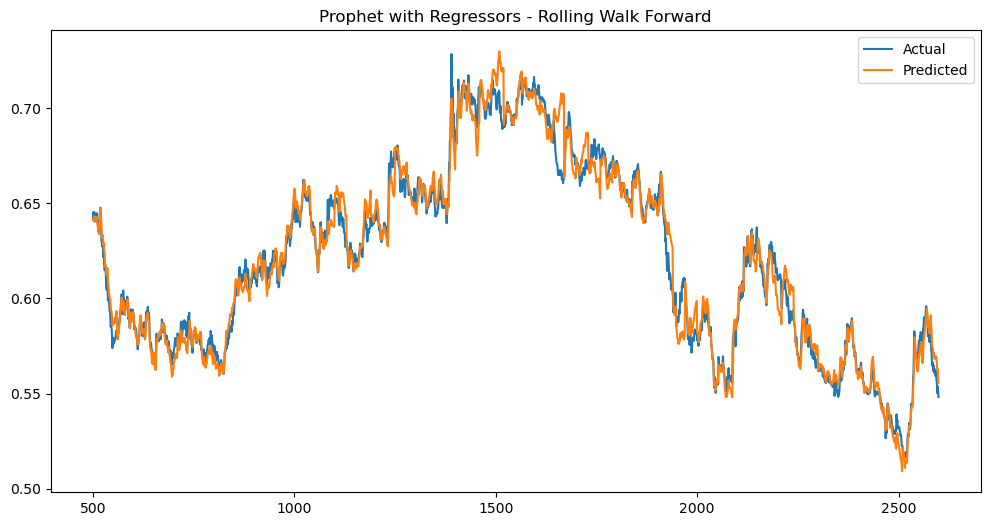

In [27]:
 
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Prepare data ===
# df = your dataframe
#df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

# Prophet requires "ds" (date) and "y" (target)
prophet_df = df[['Date', target] + features].rename(columns={'Date': 'ds', target: 'y'})

# === Walk-forward parameters ===
train_window = 500
test_window = 30

all_preds, all_actuals, all_idx = [], [], []
all_metrics = []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Walk-forward loop ===
for fold, start in enumerate(range(0, len(prophet_df) - train_window - test_window, test_window), 1):
    end = start + train_window
    train_df = prophet_df.iloc[start:end]
    test_df = prophet_df.iloc[end:end+test_window]

    # Prophet model
    model = Prophet(
        daily_seasonality=False,
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=5
    )
    for f in features:
        model.add_regressor(f)

    model.fit(train_df)

    forecast = model.predict(test_df)
    y_pred = forecast['yhat'].values
    y_test = test_df['y'].values

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(test_df.index)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_prophet = y_pred
# === Plot actual vs predicted ===
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="Predicted")
plt.legend()
plt.title("Prophet with Regressors - Rolling Walk Forward")
plt.show()


## SARIMA

Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


    Fold       MAE      RMSE          R2     ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.010921  0.011825   -0.771460   5.544513  0.611756    -0.001787   
1      2  0.199837  0.352889 -689.084731   1.770269  0.199488    -0.003620   
2      3  0.010717  0.014346   -3.871702   8.212911  0.539627    -0.006598   
3      4  0.035315  0.053595  -89.011102   2.309192  0.350917     0.000000   
4      5  0.035598  0.043176  -31.594661   3.294239  0.407343     0.000000   
..   ...       ...       ...         ...        ...       ...          ...   
65    66  0.004556  0.005339    0.281149   4.371182  0.270037    -0.005029   
66    67  0.004301  0.004919   -0.669868   3.381538  0.374997    -0.000586   
67    68  0.002980  0.003664    0.954684  13.615997  0.653266    -0.001598   
68    69  0.005129  0.005993    0.504542   8.188829  0.578353    -0.006678   
69    70  0.004898  0.005620    0.793291   3.092989  0.237069    -0.008823   

    DirAcc(%)  
0   86.206897  
1   58.620690  
2   86.206897  

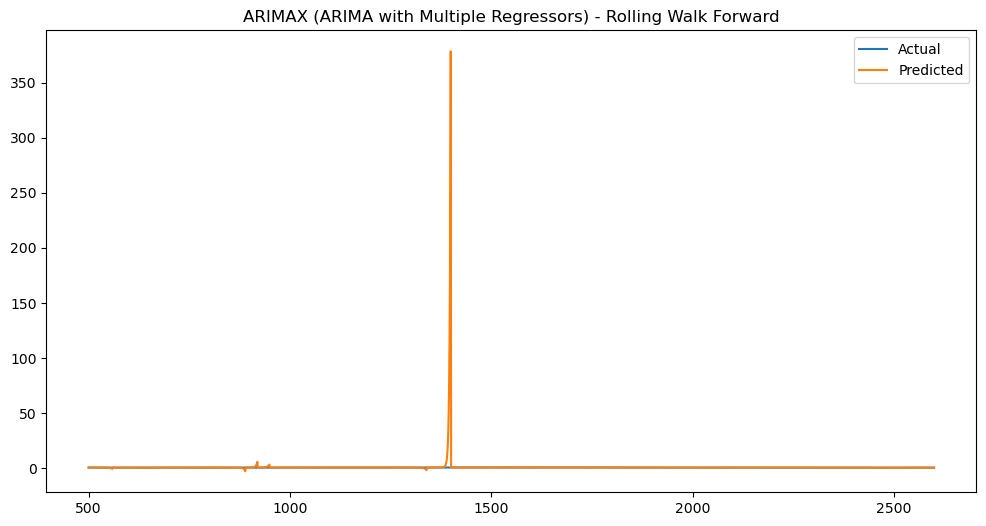

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare data ===
# df = your dataframe
df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

all_preds, all_actuals, all_idx = [], [], []
all_metrics = []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Walk-forward loop ===
for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit ARIMAX model (simple ARIMA(1,1,1) here, can tune with auto_arima)
    try:
        model = SARIMAX(y_train,
                        exog=X_train,
                        order=(1, 1, 1),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)

        y_pred = results.predict(start=len(y_train),
                                 end=len(y_train)+len(y_test)-1,
                                 exog=X_test)

    except Exception as e:
        print(f"Fold {fold} failed: {e}")
        continue

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === Plot actual vs predicted ===
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="Predicted")
plt.legend()
plt.title("ARIMAX (ARIMA with Multiple Regressors) - Rolling Walk Forward")
plt.show()


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


    Fold       MAE      RMSE         R2     ROI(%)    Sharpe  MaxDrawdown  \
0      1  0.010587  0.011536  -0.685743   5.544513  0.611756    -0.001787   
1      2  0.009371  0.010239   0.419012   2.748821  0.283075    -0.004894   
2      3  0.010792  0.014416  -3.919157   8.212911  0.539627    -0.006598   
3      4  0.036530  0.055182 -94.422163   2.309192  0.350917     0.000000   
4      5  0.010800  0.012172  -1.590360   5.137143  0.553022    -0.004049   
..   ...       ...       ...        ...        ...       ...          ...   
65    66  0.004180  0.004878   0.400109   4.458478  0.275725    -0.005029   
66    67  0.004512  0.005117  -0.807283   3.381538  0.374997    -0.000586   
67    68  0.003019  0.003759   0.952298  13.615997  0.653266    -0.001598   
68    69  0.005412  0.006381   0.438329   8.188829  0.578353    -0.006678   
69    70  0.004338  0.005027   0.834612   3.092989  0.237069    -0.008823   

    DirAcc(%)  
0   86.206897  
1   72.413793  
2   86.206897  
3   72.4137

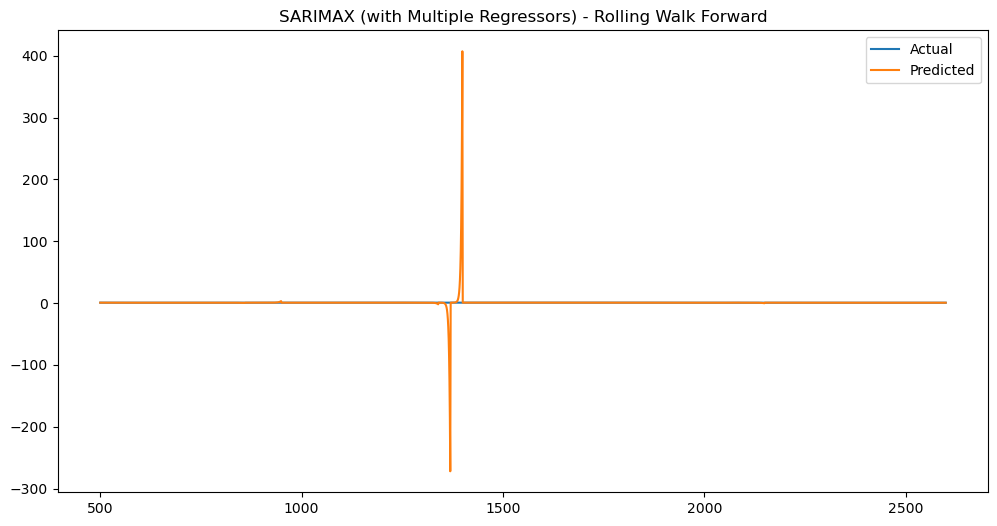

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare data ===
# df = your dataframe
#df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

all_preds, all_actuals, all_idx = [], [], []
all_metrics = []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

# === Walk-forward loop ===
for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    try:
        # SARIMAX with seasonality (set seasonal_order=(P,D,Q,s))
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=(1, 1, 1),                # ARIMA(p,d,q)
            seasonal_order=(1, 0, 1, 12),   # SARIMA(P,D,Q,s) -> here s=12 (monthly seasonality example)
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)

        y_pred = results.predict(
            start=len(y_train),
            end=len(y_train)+len(y_test)-1,
            exog=X_test
        )

    except Exception as e:
        print(f"Fold {fold} failed: {e}")
        continue

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred).pct_change().fillna(0)
    actual_returns = pd.Series(y_test).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())
y_pred_sarima = y_pred
# === Plot actual vs predicted ===
plt.figure(figsize=(12,6))
plt.plot(all_idx, all_actuals, label="Actual")
plt.plot(all_idx, all_preds, label="Predicted")
plt.legend()
plt.title("SARIMAX (with Multiple Regressors) - Rolling Walk Forward")
plt.show()


## Diebold–Mariano (DM) test i

In [30]:
from itertools import combinations
from scipy import stats

# ======================================
# Helper: Diebold-Mariano Test
# ======================================
def diebold_mariano(y_true, y_pred1, y_pred2, crit="MSE"):
    e1 = y_true - y_pred1
    e2 = y_true - y_pred2

    if crit.upper() == "MSE":
        d = e1**2 - e2**2
    elif crit.upper() == "MAE":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")

    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    p_value = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))
    return dm_stat, p_value

# ======================================
# Step 1 – Collect predictions
# ======================================
# Suppose after each model you save predictions on the SAME test folds:
# y_actual_series = actual values (same for all models!)
# Store each model's preds in a dict:

all_model_preds = {
    "LinearRegression": y_pred_lr,     # np.array or pd.Series
    "CatBoost": y_pred_cat,
    "LightGBM": y_pred_lgb,
    "MLP": y_pred_mlp,
    "SVM": y_pred_svr,
    "BiLSTM": y_pred_bilstm,
    "GRU": y_pred_gru,
    "LSTM": y_pred_lstm,
    "CNN": y_pred_cnn,
    "Prophet": y_pred_prophet,
    "SARIMA": y_pred_sarima
}

# Make sure all are aligned with actuals
y_true = np.array(y_actual_series)

# ======================================
# Step 2 – Run DM tests across all pairs
# ======================================
dm_results = []

for (m1, m2) in combinations(all_model_preds.keys(), 2):
    y1 = np.array(all_model_preds[m1])
    y2 = np.array(all_model_preds[m2])

    # Align lengths
    min_len = min(len(y_true), len(y1), len(y2))
    y_true_aligned = y_true[-min_len:]
    y1, y2 = y1[-min_len:], y2[-min_len:]

    dm_stat, p_value = diebold_mariano(y_true_aligned, y1, y2, crit="MSE")
    dm_results.append([m1, m2, dm_stat, p_value])

dm_df = pd.DataFrame(dm_results, columns=["Model 1", "Model 2", "DM Stat", "p-value"])
print("\n=== Diebold-Mariano Test Results ===")
print(dm_df)

# ======================================
# Step 3 – Average performance summary
# ======================================
perf_summary = []
for name, preds in all_model_preds.items():
    preds = np.array(preds)
    min_len = min(len(y_true), len(preds))
    y_t, y_p = y_true[-min_len:], preds[-min_len:]

    mae = mean_absolute_error(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    r2 = r2_score(y_t, y_p)

    # Trading metrics
    pred_returns = pd.Series(y_p).pct_change().fillna(0)
    actual_returns = pd.Series(y_t).pct_change().fillna(0)
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    def directional_accuracy(actual, predicted):
        actual_diff = np.diff(actual)
        pred_diff = np.diff(predicted)
        return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

    da = directional_accuracy(y_t, y_p)

    perf_summary.append([name, mae, rmse, r2, roi, sharpe, max_dd, da])

perf_df = pd.DataFrame(perf_summary, columns=[
    "Model", "MAE", "RMSE", "R2", "ROI(%)", "Sharpe", "MaxDrawdown", "DirAcc(%)"
])

print("\n=== Average Performance Across Models ===")
print(perf_df.sort_values(by="R2", ascending=False))



=== Diebold-Mariano Test Results ===
             Model 1   Model 2    DM Stat       p-value
0   LinearRegression  CatBoost   5.511601  3.555842e-08
1   LinearRegression  LightGBM   5.497412  3.854061e-08
2   LinearRegression       MLP  -8.332013  0.000000e+00
3   LinearRegression       SVM   8.479284  0.000000e+00
4   LinearRegression    BiLSTM   2.562389  1.039548e-02
5   LinearRegression       GRU   4.771907  1.824897e-06
6   LinearRegression      LSTM   5.501130  3.773654e-08
7   LinearRegression       CNN   2.486555  1.289867e-02
8   LinearRegression   Prophet   4.551947  5.315172e-06
9   LinearRegression    SARIMA   5.197144  2.023731e-07
10          CatBoost  LightGBM  -2.492408  1.268801e-02
11          CatBoost       MLP  -5.714290  1.101632e-08
12          CatBoost       SVM  -2.478413  1.319684e-02
13          CatBoost    BiLSTM  -3.878369  1.051592e-04
14          CatBoost       GRU  -3.693976  2.207747e-04
15          CatBoost      LSTM  -2.044382  4.091584e-02
16        

In [31]:
# === Save test set for reuse ===
test_set = df.iloc[end:end+test_window].copy()

# Save to CSV
test_set.to_csv("forex_test_set.csv", index=False)

# Or save as pickle (preserves dtypes better)
import pickle
with open("forex_test_set.pkl", "wb") as f:
    pickle.dump(test_set, f)

print("✅ Test set saved: forex_test_set.csv and forex_test_set.pkl")


✅ Test set saved: forex_test_set.csv and forex_test_set.pkl
